In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt

### Formatting

In [2]:
# FORMATTING SETTINGS HERE

### Preprocessing

In [3]:
task_array_path = "../../task_arrays/benchtm_varyp.tasks.tsv"
res_path = "../../../output/benchtm_varyp/benchtm_varyp.combined.tsv"

In [4]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [5]:
# Aggregate results
setting_identifiers = ["scenario", "strategy", "bonf_strategy", "n_burn_in", "train_ratio",
                       "margin_width"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_se",
                                                     "region_mass_mean", "region_mass_se"]]

In [6]:
# Add DGP /heterogeneity settings
agg_res_df["dgp_scen"] = 1 + ((agg_res_df.scenario - 1) // 5)
agg_res_df["het_scen"] = 1 + ((agg_res_df.scenario - 1) % 5)

### Settings

In [7]:
# Heterogeneity settings
dgp_settings = [1,2,3,4,5]
het_settings = [1,2,3,4,5]

# Chiseling
margin_width_settings = [0,0.5,1]

### Standardize by optimal region utilities

In [8]:
opt_metrics_df = pd.read_csv("../../../benchtm/benchtm_opt_metrics.tsv", sep="\t")
opt_metrics_df = opt_metrics_df.set_index("scenario")

In [9]:
# utility, size, mean, and standard errors
opt_region_metrics_dict = {}
for scenario in dgp_settings:
    utility, size, sate = opt_metrics_df.loc[scenario].loc[["utility", "size", "subgroup_mean"]].values
    opt_region_metrics_dict[scenario] = (utility, size, sate, 0, 0, 0)

In [10]:
# Calculate normalized utilities
agg_res_df["opt_utility"] = agg_res_df.apply(lambda row:
                                             opt_region_metrics_dict[row.scenario][0],
                                             axis=1)
agg_res_df["norm_subgroup_utility_mean"] = (agg_res_df["subgroup_utility_mean"] /
                                            agg_res_df["opt_utility"])

### Visualizations

Expected utility

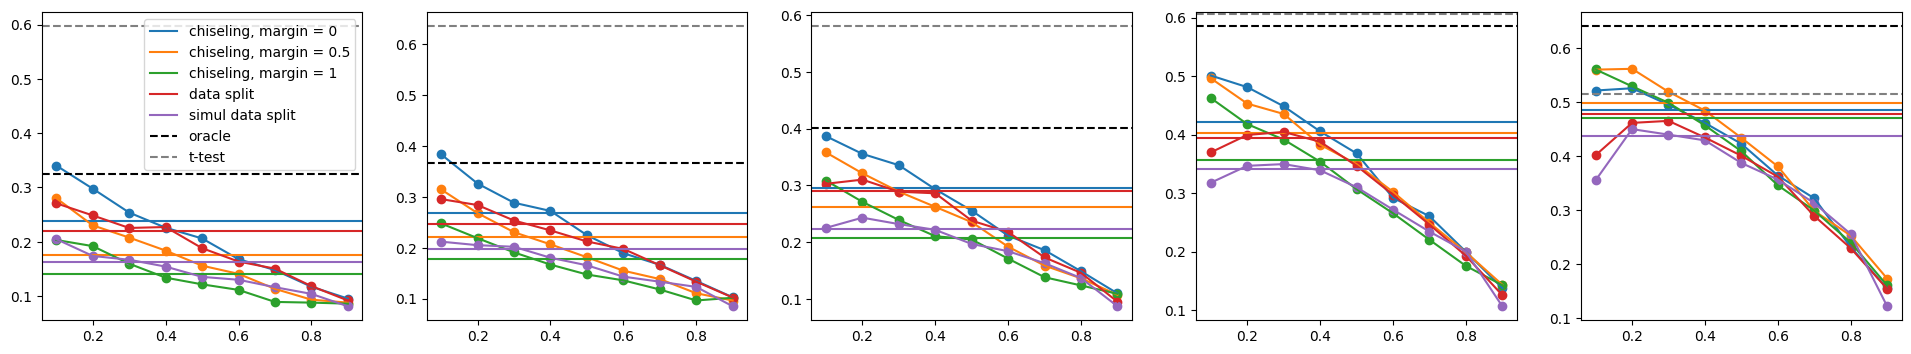

In [11]:
fig, ax = plt.subplots(1,5,figsize=(24,4))

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for het_scen in het_settings:
    sub_res_df = agg_res_df[agg_res_df.het_scen == het_scen]
    # Chiseling methods
    for margin_width in margin_width_settings:
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.norm_subgroup_utility_mean,
                     label="chiseling, margin = {}".format(margin_width))
        last_color = ax[AX0].get_lines()[-1].get_color()
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.norm_subgroup_utility_mean,
                        color=last_color)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0], color=last_color)
    # Data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.norm_subgroup_utility_mean,
                 label="data split")
    last_color = ax[AX0].get_lines()[-1].get_color()
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.norm_subgroup_utility_mean,
                    color=last_color)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0], color=last_color)
    # Simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.norm_subgroup_utility_mean,
                 label="simul data split")
    last_color = ax[AX0].get_lines()[-1].get_color()
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.norm_subgroup_utility_mean,
                    color=last_color)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0], color=last_color)
    # Oracle
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0],
                    label="oracle", linestyle="--", color="black")
    # T-test
    sub_sub_res_df = sub_res_df[sub_res_df.strategy == "TTestStrategy"]
    ax[AX0].axhline(sub_sub_res_df.norm_subgroup_utility_mean.values[0],
                    label="t-test", linestyle="--", color="gray")
    # Set ylim
    # ax[AX0].set_ylim(0,1+0.01)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

ax[0].legend()

plt.show()

Power

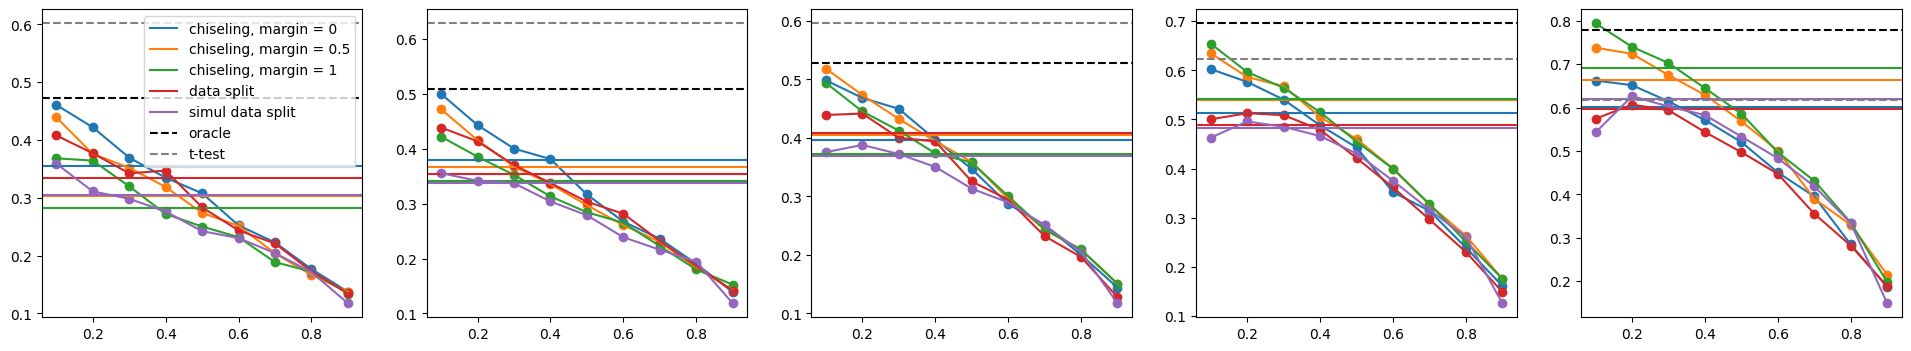

In [12]:
fig, ax = plt.subplots(1,5,figsize=(24,4))

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for het_scen in het_settings:
    sub_res_df = agg_res_df[agg_res_df.het_scen == het_scen]
    # Chiseling methods
    for margin_width in margin_width_settings:
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.rejected_mean,
                     label="chiseling, margin = {}".format(margin_width))
        last_color = ax[AX0].get_lines()[-1].get_color()
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.rejected_mean,
                        color=last_color)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0], color=last_color)
    # Data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.rejected_mean,
                 label="data split")
    last_color = ax[AX0].get_lines()[-1].get_color()
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.rejected_mean,
                    color=last_color)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0], color=last_color)
    # Simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.rejected_mean,
                 label="simul data split")
    last_color = ax[AX0].get_lines()[-1].get_color()
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.rejected_mean,
                    color=last_color)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0], color=last_color)
    # Oracle
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0],
                    label="oracle", linestyle="--", color="black")
    # T-test
    sub_sub_res_df = sub_res_df[sub_res_df.strategy == "TTestStrategy"]
    ax[AX0].axhline(sub_sub_res_df.rejected_mean.values[0],
                    label="t-test", linestyle="--", color="gray")
    # Set ylim
    # ax[AX0].set_ylim(0,1+0.01)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

ax[0].legend()

plt.show()

### Type I error

In [13]:
res_df["error"] = res_df.rejected & (res_df.subgroup_utility <= 0)

In [14]:
setting_identifiers = ["scenario", "strategy", "bonf_strategy", "n_burn_in", "train_ratio",
                       "margin_width"]
error_df = res_df.groupby(setting_identifiers, dropna=False)[["error"]].agg(["mean", "var", "count"])
error_df.columns = ["_".join(c) for c in error_df.columns.to_flat_index()]
error_df = error_df.reset_index()
error_df["error_se"] = np.sqrt(error_df.error_var / error_df.error_count)

error_df = error_df.loc[:,setting_identifiers + ["error_mean", "error_se"]]

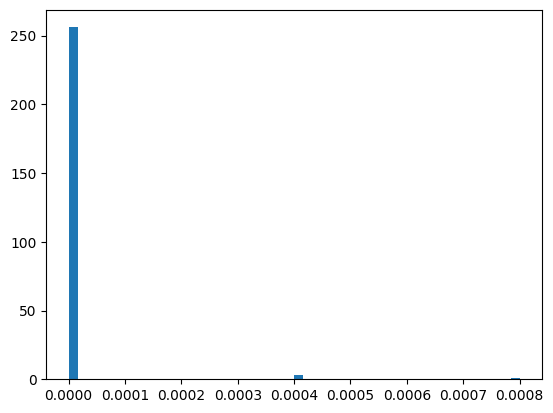

Min = 0.0 / Max = 0.0008


In [15]:
plt.hist(error_df.error_mean.values, bins=50)
plt.show()

print("Min = {} / Max = {}".format(error_df.error_mean.min(), error_df.error_mean.max()))